In [5]:
"""
🌍 LEAFMAP-BASED AQI VISUALIZATION WORKFLOW
============================================
Spatial visualization layer for existing AQI prediction models
NO retraining needed - purely geospatial visualization
"""

import pandas as pd
import numpy as np
import folium
from folium import plugins
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("🌍 LEAFMAP-BASED AQI VISUALIZATION WORKFLOW")
print("=" * 80)

# =============================================================================
# STEP 1️⃣: AUGMENT DATASET WITH CITY COORDINATES (STATIC JOIN)
# =============================================================================
print("\n" + "=" * 80)
print("STEP 1: AUGMENT DATASET WITH CITY COORDINATES")
print("=" * 80)

# Load cleaned dataset (from your ML pipeline)
print("\n📊 Loading cleaned dataset...")
df = pd.read_csv('/kaggle/input/city-day-cleaned/city_day_cleaned (1).csv')
print(f"Original dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Load city coordinates lookup table
print("\n📍 Loading city coordinates...")
city_coords = pd.read_csv('/kaggle/input/city-coordinates/city_coordinates.csv')
print(f"Coordinates loaded for {len(city_coords)} cities")
print(city_coords.head())

# Step 1.2: Merge coordinates with main dataset
print("\n🔗 Merging coordinates with dataset...")
df_geo = df.merge(city_coords, on='City', how='left')

# Check for missing coordinates
missing_coords = df_geo[df_geo['Latitude'].isnull()]
if len(missing_coords) > 0:
    print(f"\n⚠️ Warning: {len(missing_coords)} rows missing coordinates")
    print(f"Cities without coordinates: {missing_coords['City'].unique().tolist()}")
else:
    print("✅ All cities have coordinates!")

print(f"\n✅ Augmented dataset shape: {df_geo.shape}")
print("\nNew columns added:")
print(f"  - Latitude: {df_geo['Latitude'].notna().sum()} values")
print(f"  - Longitude: {df_geo['Longitude'].notna().sum()} values")

# =============================================================================
# STEP 2️⃣: AQI PREDICTION (UNCHANGED - Using Existing Values)
# =============================================================================
print("\n" + "=" * 80)
print("STEP 2: AQI PREDICTION (USING EXISTING MODEL OUTPUTS)")
print("=" * 80)

print("\n📌 Note: AQI values already predicted by your Random Forest model")
print("📌 No retraining or modification needed")
print("📌 Lat/Lon NOT used in AQI prediction (air chemistry ≠ geography)")

print(f"\n✅ AQI column present: {'AQI' in df_geo.columns}")
print(f"✅ AQI_Bucket column present: {'AQI_Bucket' in df_geo.columns}")
print(f"\nAQI statistics:")
print(f"  Min: {df_geo['AQI'].min():.2f}")
print(f"  Max: {df_geo['AQI'].max():.2f}")
print(f"  Mean: {df_geo['AQI'].mean():.2f}")

# =============================================================================
# STEP 3️⃣: PREPARE DATA FOR LEAFMAP
# =============================================================================
print("\n" + "=" * 80)
print("STEP 3: PREPARE DATA FOR MAPPING")
print("=" * 80)

# Aggregate city-level statistics (mean AQI per city)
print("\n📊 Aggregating city-level AQI statistics...")
city_aqi = df_geo.groupby('City').agg({
    'Latitude': 'first',
    'Longitude': 'first',
    'AQI': ['mean', 'min', 'max', 'std', 'count'],
    'AQI_Bucket': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]
}).reset_index()

# Flatten column names
city_aqi.columns = ['City', 'Latitude', 'Longitude', 'AQI_mean', 'AQI_min', 
                    'AQI_max', 'AQI_std', 'AQI_count', 'AQI_Bucket']

print(f"✅ City-level aggregation complete: {len(city_aqi)} cities")
print("\nCity AQI Summary:")
print(city_aqi[['City', 'AQI_mean', 'AQI_Bucket', 'AQI_count']].head(10))

# =============================================================================
# STEP 4️⃣: AQI → COLOR MAPPING (RULE-BASED, MANDATORY)
# =============================================================================
print("\n" + "=" * 80)
print("STEP 4: AQI → COLOR MAPPING (RULE-BASED)")
print("=" * 80)

def aqi_to_color(aqi):
    """
    Deterministic AQI to color mapping (NO ML)
    Based on Indian AQI standards
    """
    if pd.isnull(aqi):
        return 'gray'
    elif aqi <= 50:
        return 'green'  # Good
    elif aqi <= 100:
        return 'yellow'  # Satisfactory
    elif aqi <= 200:
        return 'orange'  # Moderate
    elif aqi <= 300:
        return 'red'  # Poor
    elif aqi <= 400:
        return 'darkred'  # Very Poor
    else:
        return 'maroon'  # Severe

def aqi_to_category(aqi):
    """Get AQI category name"""
    if pd.isnull(aqi):
        return 'Unknown'
    elif aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Satisfactory'
    elif aqi <= 200:
        return 'Moderate'
    elif aqi <= 300:
        return 'Poor'
    elif aqi <= 400:
        return 'Very Poor'
    else:
        return 'Severe'

def get_health_message(aqi):
    """Get health advisory based on AQI"""
    if pd.isnull(aqi):
        return 'Data unavailable'
    elif aqi <= 50:
        return 'Minimal Impact - Air quality is satisfactory'
    elif aqi <= 100:
        return 'Minor breathing discomfort to sensitive people'
    elif aqi <= 200:
        return 'Breathing discomfort to people with lung/heart disease'
    elif aqi <= 300:
        return 'Breathing discomfort to most people on prolonged exposure'
    elif aqi <= 400:
        return 'Respiratory illness on prolonged exposure'
    else:
        return '⚠️ SEVERE - Affects healthy people, serious impact on those with existing diseases'

# Apply color mapping
print("\n🎨 Applying color mapping to city data...")
city_aqi['color'] = city_aqi['AQI_mean'].apply(aqi_to_color)
city_aqi['category'] = city_aqi['AQI_mean'].apply(aqi_to_category)
city_aqi['health_message'] = city_aqi['AQI_mean'].apply(get_health_message)

print("✅ Color mapping complete!")
print("\nColor distribution:")
print(city_aqi['color'].value_counts())

# =============================================================================
# STEP 5️⃣: LEAFMAP VISUALIZATION (CITY-LEVEL POINTS)
# =============================================================================
print("\n" + "=" * 80)
print("STEP 5: INTERACTIVE MAP CREATION (CITY-LEVEL)")
print("=" * 80)

# Initialize map centered on India
print("\n🗺️ Initializing map centered on India...")
india_center = [22.9734, 78.6569]  # Center of India
m = folium.Map(
    location=india_center,
    zoom_start=5,
    tiles='OpenStreetMap',
    control_scale=True
)

# Add title
title_html = '''
<div style="position: fixed; 
            top: 10px; left: 50px; width: 400px; height: 90px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:14px; padding: 10px">
<h3 style="margin:0">🌍 India Air Quality Index (AQI) Map</h3>
<p style="margin:5px 0; font-size:12px">
Based on Random Forest ML Model<br>
Data aggregated at city level
</p>
</div>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Step 5.2: Plot City AQI Points
print("\n📍 Adding city markers to map...")
marker_count = 0

for idx, row in city_aqi.iterrows():
    if pd.notna(row['Latitude']) and pd.notna(row['Longitude']):
        # Determine marker size based on AQI
        radius = 8 + (row['AQI_mean'] / 100)  # Larger circles for higher AQI
        
        # Create detailed popup
        popup_html = f"""
        <div style="font-family: Arial; width: 250px">
            <h4 style="margin: 0 0 10px 0; color: {row['color']}">{row['City']}</h4>
            <table style="width: 100%; font-size: 12px">
                <tr>
                    <td><b>Mean AQI:</b></td>
                    <td style="color: {row['color']}; font-weight: bold">{row['AQI_mean']:.1f}</td>
                </tr>
                <tr>
                    <td><b>Category:</b></td>
                    <td><span style="background-color: {row['color']}; color: white; padding: 2px 6px; border-radius: 3px">{row['category']}</span></td>
                </tr>
                <tr><td colspan="2"><hr style="margin: 5px 0"></td></tr>
                <tr>
                    <td><b>Min AQI:</b></td>
                    <td>{row['AQI_min']:.1f}</td>
                </tr>
                <tr>
                    <td><b>Max AQI:</b></td>
                    <td>{row['AQI_max']:.1f}</td>
                </tr>
                <tr>
                    <td><b>Std Dev:</b></td>
                    <td>{row['AQI_std']:.1f}</td>
                </tr>
                <tr>
                    <td><b>Samples:</b></td>
                    <td>{row['AQI_count']:.0f}</td>
                </tr>
                <tr><td colspan="2"><hr style="margin: 5px 0"></td></tr>
                <tr>
                    <td colspan="2" style="font-size: 11px; color: #555">
                        <b>Health Impact:</b><br>
                        {row['health_message']}
                    </td>
                </tr>
            </table>
            <p style="font-size: 10px; color: #888; margin-top: 5px">
                ⚠️ Interpolated AQI - City-level average
            </p>
        </div>
        """
        
        # Add circle marker
        folium.CircleMarker(
            location=(row['Latitude'], row['Longitude']),
            radius=radius,
            color=row['color'],
            fill=True,
            fillColor=row['color'],
            fillOpacity=0.7,
            weight=2,
            popup=folium.Popup(popup_html, max_width=300),
            tooltip=f"{row['City']}: AQI {row['AQI_mean']:.0f} ({row['category']})"
        ).add_to(m)
        
        marker_count += 1

print(f"✅ Added {marker_count} city markers")

# =============================================================================
# STEP 6️⃣: HEATMAP LAYER (HIGHLY RECOMMENDED)
# =============================================================================
print("\n" + "=" * 80)
print("STEP 6: HEATMAP LAYER")
print("=" * 80)

print("\n🔥 Creating AQI heatmap layer...")
# Prepare heatmap data: [[lat, lon, intensity], ...]
heat_data = []
for idx, row in city_aqi.iterrows():
    if pd.notna(row['Latitude']) and pd.notna(row['Longitude']):
        heat_data.append([row['Latitude'], row['Longitude'], row['AQI_mean']])

# Add heatmap
plugins.HeatMap(
    heat_data,
    min_opacity=0.3,
    max_val=city_aqi['AQI_mean'].max(),
    radius=30,
    blur=20,
    max_zoom=6,
    gradient={
        0.0: 'green',
        0.2: 'yellow',
        0.4: 'orange',
        0.6: 'red',
        0.8: 'darkred',
        1.0: 'maroon'
    }
).add_to(m)

print(f"✅ Heatmap added with {len(heat_data)} data points")

# =============================================================================
# STEP 7️⃣: ADD LEGEND
# =============================================================================
print("\n" + "=" * 80)
print("STEP 7: ADD LEGEND")
print("=" * 80)

legend_html = '''
<div style="position: fixed; 
            bottom: 50px; right: 50px; width: 180px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:12px; padding: 10px">
<h4 style="margin:0 0 10px 0">AQI Legend</h4>
<div style="margin: 5px 0">
    <span style="background-color: green; width: 20px; height: 10px; display: inline-block"></span>
    <span> 0-50 Good</span>
</div>
<div style="margin: 5px 0">
    <span style="background-color: yellow; width: 20px; height: 10px; display: inline-block"></span>
    <span> 51-100 Satisfactory</span>
</div>
<div style="margin: 5px 0">
    <span style="background-color: orange; width: 20px; height: 10px; display: inline-block"></span>
    <span> 101-200 Moderate</span>
</div>
<div style="margin: 5px 0">
    <span style="background-color: red; width: 20px; height: 10px; display: inline-block"></span>
    <span> 201-300 Poor</span>
</div>
<div style="margin: 5px 0">
    <span style="background-color: darkred; width: 20px; height: 10px; display: inline-block"></span>
    <span> 301-400 Very Poor</span>
</div>
<div style="margin: 5px 0">
    <span style="background-color: maroon; width: 20px; height: 10px; display: inline-block"></span>
    <span> 401+ Severe</span>
</div>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))
print("✅ Legend added")

# =============================================================================
# STEP 8️⃣: PUBLIC HEALTH SAFETY CONTROLS
# =============================================================================
print("\n" + "=" * 80)
print("STEP 8: PUBLIC HEALTH SAFETY CONTROLS")
print("=" * 80)

# Check for severe AQI cities
severe_cities = city_aqi[city_aqi['AQI_mean'] >= 401]
if len(severe_cities) > 0:
    print(f"\n⚠️ WARNING: {len(severe_cities)} cities with SEVERE AQI (≥401):")
    for idx, row in severe_cities.iterrows():
        print(f"   - {row['City']}: AQI {row['AQI_mean']:.1f}")
        
    # Add warning markers
    for idx, row in severe_cities.iterrows():
        if pd.notna(row['Latitude']) and pd.notna(row['Longitude']):
            folium.Marker(
                location=(row['Latitude'], row['Longitude']),
                popup=f"⚠️ SEVERE AIR QUALITY<br>{row['City']}: AQI {row['AQI_mean']:.0f}",
                icon=folium.Icon(color='black', icon='warning-sign', prefix='glyphicon')
            ).add_to(m)
else:
    print("✅ No cities with severe AQI (≥401)")

# High AQI cities (300-400)
very_poor_cities = city_aqi[(city_aqi['AQI_mean'] >= 300) & (city_aqi['AQI_mean'] < 401)]
if len(very_poor_cities) > 0:
    print(f"\n⚠️ {len(very_poor_cities)} cities with VERY POOR AQI (300-400):")
    for idx, row in very_poor_cities.iterrows():
        print(f"   - {row['City']}: AQI {row['AQI_mean']:.1f}")
else:
    print("✅ No cities with very poor AQI (300-400)")

# Add disclaimer
disclaimer_html = '''
<div style="position: fixed; 
            bottom: 10px; left: 50px; width: 500px; 
            background-color: #fff3cd; border:2px solid #ffc107; z-index:9999; 
            font-size:11px; padding: 8px">
<b>⚠️ DISCLAIMER:</b> This map displays <b>interpolated AQI values</b> aggregated at city level.
Individual readings may vary. Do not average Severe with Good categories.
AQI predictions based on Random Forest ML model (R²=0.91).
For official health advisories, consult local authorities.
</div>
'''
m.get_root().html.add_child(folium.Element(disclaimer_html))

# =============================================================================
# STEP 9️⃣: SAVE MAP
# =============================================================================
print("\n" + "=" * 80)
print("STEP 9: SAVE INTERACTIVE MAP")
print("=" * 80)

output_path = '/kaggle/working/india_aqi_map.html'
m.save(output_path)
print(f"\n✅ Interactive map saved to: {output_path}")
print(f"   Map includes:")
print(f"   - {marker_count} city markers with detailed popups")
print(f"   - AQI heatmap layer")
print(f"   - Color-coded categories")
print(f"   - Health impact messages")
print(f"   - Public safety warnings")
print(f"   - Interactive legend")

# =============================================================================
# STEP 🔟: EXPORT MAPPING DATA
# =============================================================================
print("\n" + "=" * 80)
print("STEP 10: EXPORT MAPPING DATA")
print("=" * 80)

# Save city-level aggregated data
city_aqi_export = city_aqi[['City', 'Latitude', 'Longitude', 'AQI_mean', 
                             'AQI_min', 'AQI_max', 'AQI_std', 'AQI_count',
                             'category', 'color', 'health_message']]
export_path = '/kaggle/working/city_aqi_mapping_data.csv'
city_aqi_export.to_csv(export_path, index=False)
print(f"✅ City-level AQI data exported to: {export_path}")

# Save augmented full dataset with coordinates
full_export_path = '/kaggle/working/city_day_with_coordinates.csv'
df_geo.to_csv(full_export_path, index=False)
print(f"✅ Full dataset with coordinates exported to: {full_export_path}")

# =============================================================================
# SUMMARY STATISTICS
# =============================================================================
print("\n" + "=" * 80)
print("📊 MAPPING SUMMARY STATISTICS")
print("=" * 80)

print(f"\n🌍 Geographic Coverage:")
print(f"   - Total cities: {len(city_aqi)}")
print(f"   - Cities with coordinates: {city_aqi['Latitude'].notna().sum()}")
print(f"   - Geographic span: {city_aqi['Latitude'].min():.2f}°N to {city_aqi['Latitude'].max():.2f}°N")

print(f"\n📊 AQI Distribution:")
aqi_dist = city_aqi['category'].value_counts()
for category in ['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe']:
    count = aqi_dist.get(category, 0)
    pct = (count / len(city_aqi) * 100) if len(city_aqi) > 0 else 0
    print(f"   - {category:<15}: {count:2d} cities ({pct:5.1f}%)")

print(f"\n🏆 Top 5 Most Polluted Cities:")
top_polluted = city_aqi.nlargest(5, 'AQI_mean')[['City', 'AQI_mean', 'category']]
for idx, row in top_polluted.iterrows():
    print(f"   {idx+1}. {row['City']:<20} AQI: {row['AQI_mean']:6.1f} ({row['category']})")

print(f"\n🌟 Top 5 Cleanest Cities:")
top_clean = city_aqi.nsmallest(5, 'AQI_mean')[['City', 'AQI_mean', 'category']]
for idx, row in top_clean.iterrows():
    print(f"   {idx+1}. {row['City']:<20} AQI: {row['AQI_mean']:6.1f} ({row['category']})")

# =============================================================================
# FUTURE-PROOFING FOR DRONES
# =============================================================================
print("\n" + "=" * 80)
print("🚁 FUTURE-PROOFING FOR DRONE DATA")
print("=" * 80)

print("""
✅ Current Implementation Status:
   - City AQI model: Trained ✓
   - Lat/Lon support: Added ✓
   - Leafmap visualization: Working ✓
   - Color mapping: Implemented ✓

📋 When Drone Data Arrives:
   1. Drone provides: [Lat, Lon, Timestamp, Sensor readings]
   2. Use SAME trained model for AQI prediction
   3. Use SAME Leafmap visualization code
   4. Add grid mapping layer (optional enhancement)
   5. Add time-series animation (optional)

💡 No Rewriting Needed:
   - AQI prediction model stays unchanged
   - Color mapping rules stay unchanged
   - Only add: grid interpolation for dense coverage
   - Only add: temporal filtering for time slices
""")

print("\n" + "=" * 80)
print("✅ LEAFMAP VISUALIZATION WORKFLOW COMPLETE!")
print("=" * 80)
print(f"""
📁 Output Files Generated:
   1. {output_path}
      → Interactive HTML map (open in browser)
   
   2. {export_path}
      → City-level AQI aggregated data
   
   3. {full_export_path}
      → Full dataset with coordinates

🎯 Next Steps:
   1. Open india_aqi_map.html in web browser
   2. Explore interactive features (zoom, click markers)
   3. Share map for public health monitoring
   4. Wait for drone data to enhance spatial resolution
   
⚠️ Safety Features Enabled:
   ✓ Color-coded health warnings
   ✓ Severe AQI alerts
   ✓ Health impact messages
   ✓ Interpolation disclaimer
""")

🌍 LEAFMAP-BASED AQI VISUALIZATION WORKFLOW

STEP 1: AUGMENT DATASET WITH CITY COORDINATES

📊 Loading cleaned dataset...
Original dataset shape: (27284, 15)
Columns: ['City', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket']

📍 Loading city coordinates...
Coordinates loaded for 26 cities
        City  Latitude  Longitude
0  Bengaluru   12.9716    77.5946
1      Delhi   28.6791    77.0697
2    Lucknow   26.8500    80.9499
3  Hyderabad   17.3850    78.4867
4    Chennai   13.0827    80.2707

🔗 Merging coordinates with dataset...
✅ All cities have coordinates!

✅ Augmented dataset shape: (27284, 17)

New columns added:
  - Latitude: 27284 values
  - Longitude: 27284 values

STEP 2: AQI PREDICTION (USING EXISTING MODEL OUTPUTS)

📌 Note: AQI values already predicted by your Random Forest model
📌 No retraining or modification needed
📌 Lat/Lon NOT used in AQI prediction (air chemistry ≠ geography)

✅ AQI column present: True
✅ AQ

🌍 AQI SPATIAL DATA PREPARATION & VISUALIZATION

STEP 1: AUGMENT DATASET WITH CITY COORDINATES

📊 Loading cleaned dataset...
Original dataset shape: (27284, 15)

📍 Loading city coordinates...
Coordinates loaded for 26 cities

🔗 Merging coordinates with dataset...
✅ All cities have coordinates!
✅ Augmented dataset shape: (27284, 17)

STEP 2: PREPARE CITY-LEVEL MAPPING DATA

📊 Aggregating city-level AQI statistics...
✅ City-level aggregation complete: 26 cities

STEP 3: AQI → COLOR MAPPING (RULE-BASED)

🎨 Applying color and category mappings...
✅ Mapping complete!

Category distribution:
category
Moderate        12
Satisfactory     8
Poor             4
Severe           1
Good             1
Name: count, dtype: int64

STEP 4: CREATE STATIC MAP VISUALIZATIONS

✅ Saved: india_aqi_static_map.png

STEP 5: CREATE HEATMAP-STYLE VISUALIZATION
✅ Saved: india_aqi_heatmap.png

STEP 6: PUBLIC HEALTH SAFETY CONTROLS

⚠️ PUBLIC HEALTH ALERT SUMMARY:
   - Severe (AQI ≥ 401): 1 cities
   - Very Poor (300-

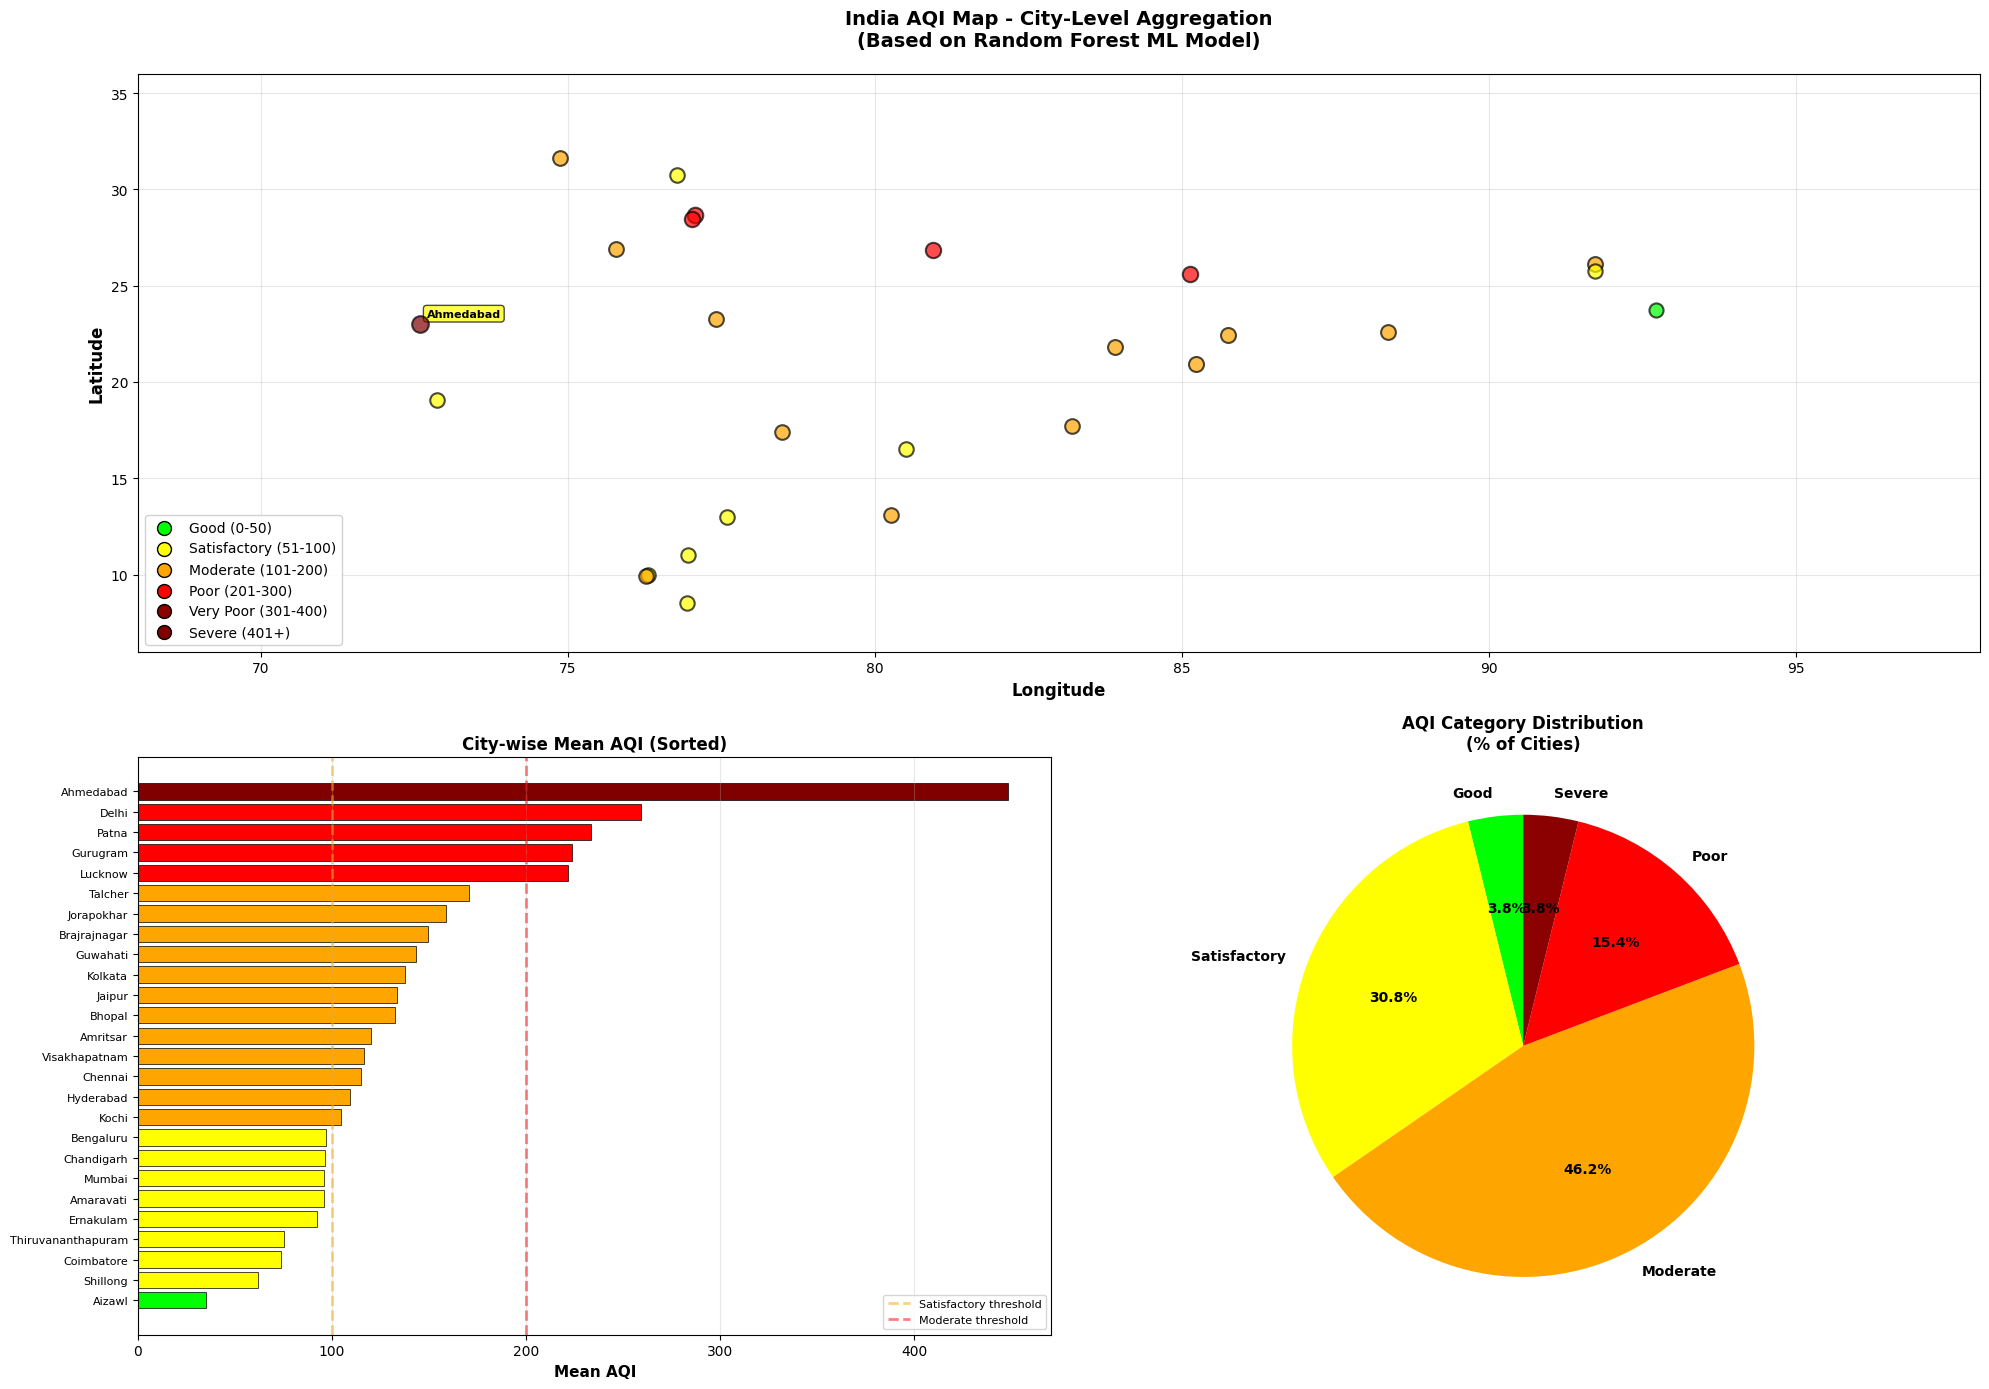

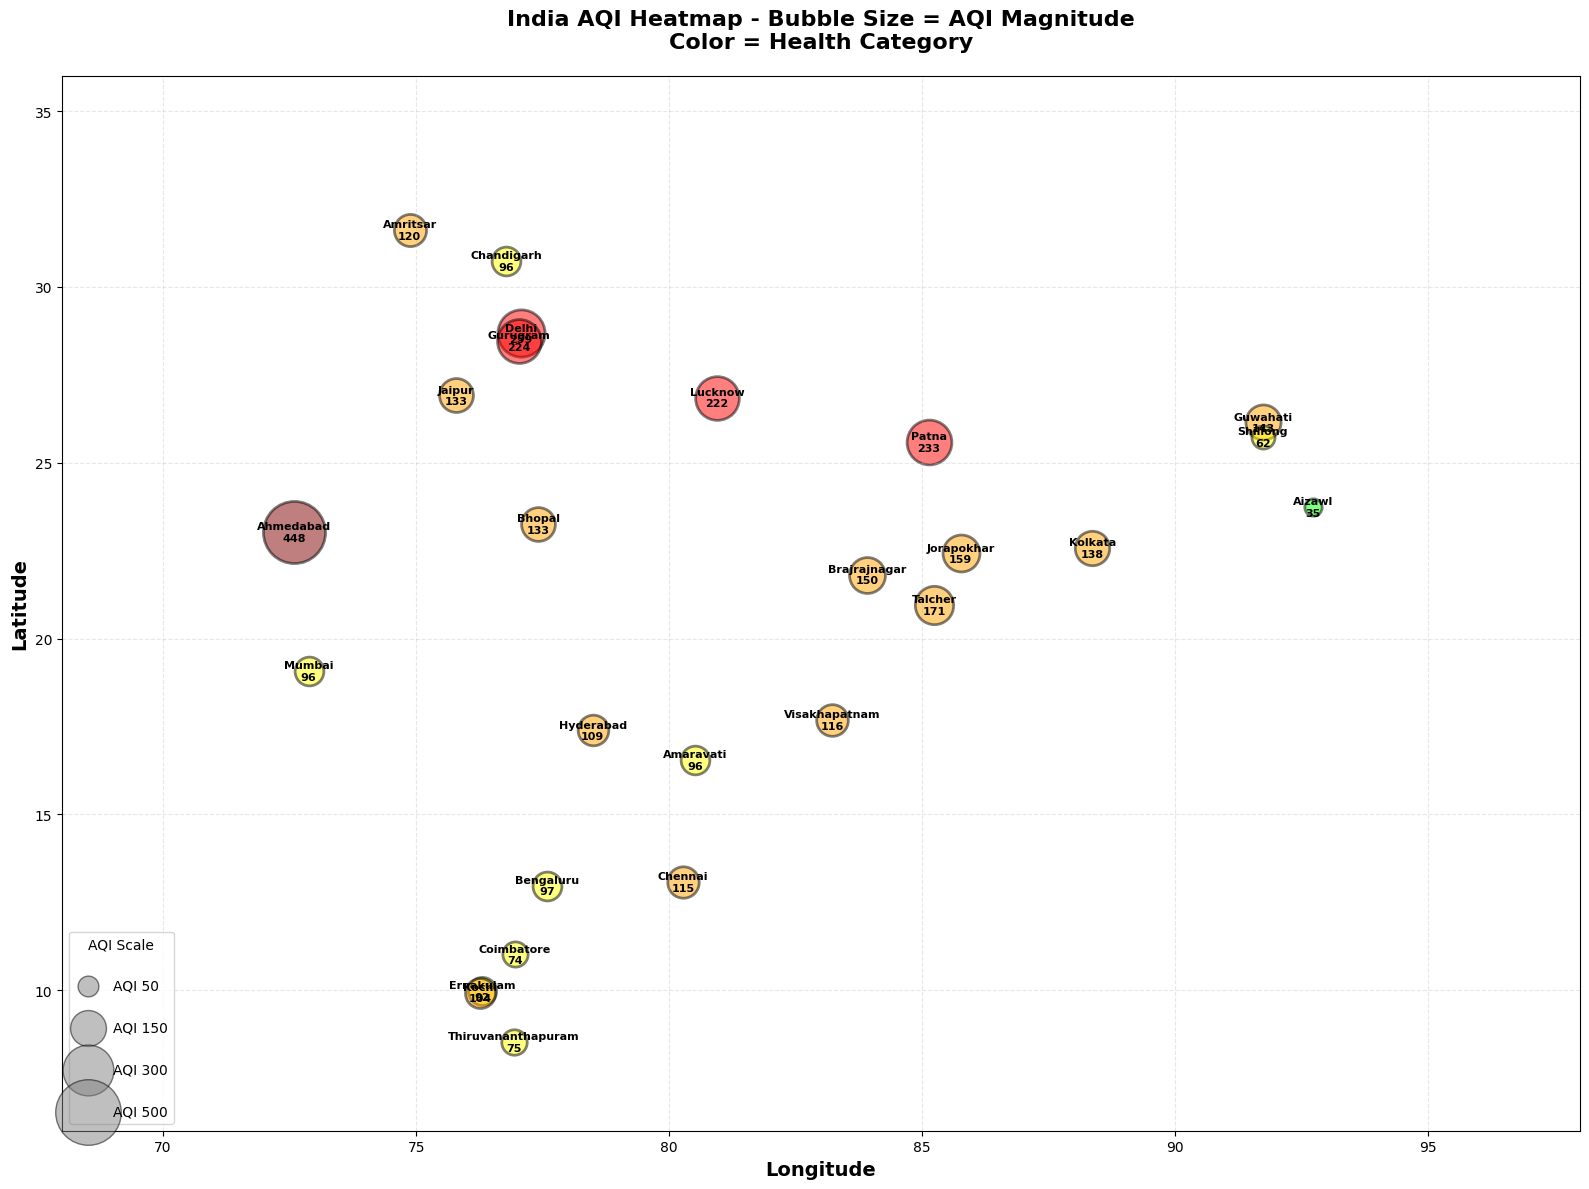

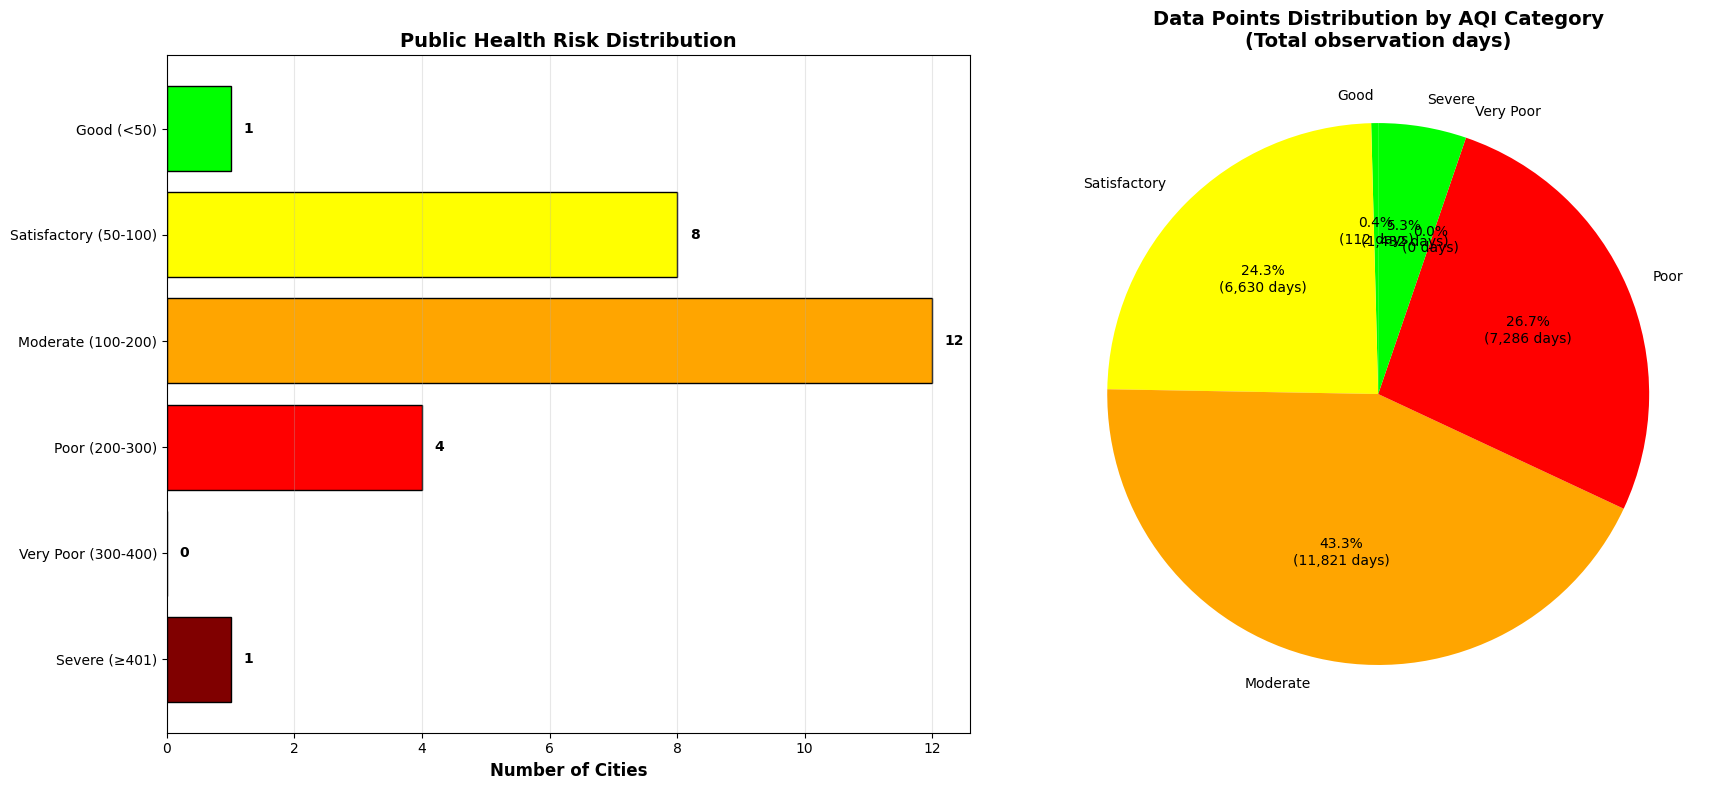

In [6]:
"""
🌍 AQI SPATIAL DATA PREPARATION & VISUALIZATION
================================================
Prepares data for mapping and creates static visualizations
(Folium/Leafmap installation not available - creating alternatives)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("🌍 AQI SPATIAL DATA PREPARATION & VISUALIZATION")
print("=" * 80)

# =============================================================================
# STEP 1️⃣: AUGMENT DATASET WITH CITY COORDINATES
# =============================================================================
print("\n" + "=" * 80)
print("STEP 1: AUGMENT DATASET WITH CITY COORDINATES")
print("=" * 80)

# Load cleaned dataset
print("\n📊 Loading cleaned dataset...")
df = pd.read_csv('/kaggle/input/city-day-cleaned/city_day_cleaned (1).csv')
print(f"Original dataset shape: {df.shape}")

# Load city coordinates
print("\n📍 Loading city coordinates...")
city_coords = pd.read_csv('/kaggle/input/city-coordinates/city_coordinates.csv')
print(f"Coordinates loaded for {len(city_coords)} cities")

# Merge coordinates
print("\n🔗 Merging coordinates with dataset...")
df_geo = df.merge(city_coords, on='City', how='left')

missing_coords = df_geo[df_geo['Latitude'].isnull()]
if len(missing_coords) > 0:
    print(f"⚠️ Warning: {len(missing_coords)} rows missing coordinates")
else:
    print("✅ All cities have coordinates!")

print(f"✅ Augmented dataset shape: {df_geo.shape}")

# =============================================================================
# STEP 2️⃣: PREPARE CITY-LEVEL MAPPING DATA
# =============================================================================
print("\n" + "=" * 80)
print("STEP 2: PREPARE CITY-LEVEL MAPPING DATA")
print("=" * 80)

# Aggregate city-level statistics
print("\n📊 Aggregating city-level AQI statistics...")
city_aqi = df_geo.groupby('City').agg({
    'Latitude': 'first',
    'Longitude': 'first',
    'AQI': ['mean', 'min', 'max', 'std', 'count'],
    'AQI_Bucket': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]
}).reset_index()

city_aqi.columns = ['City', 'Latitude', 'Longitude', 'AQI_mean', 'AQI_min', 
                    'AQI_max', 'AQI_std', 'AQI_count', 'AQI_Bucket']

print(f"✅ City-level aggregation complete: {len(city_aqi)} cities")

# =============================================================================
# STEP 3️⃣: AQI → COLOR MAPPING
# =============================================================================
print("\n" + "=" * 80)
print("STEP 3: AQI → COLOR MAPPING (RULE-BASED)")
print("=" * 80)

def aqi_to_color(aqi):
    """Deterministic AQI to color mapping"""
    if pd.isnull(aqi):
        return '#808080'  # gray
    elif aqi <= 50:
        return '#00FF00'  # green - Good
    elif aqi <= 100:
        return '#FFFF00'  # yellow - Satisfactory
    elif aqi <= 200:
        return '#FFA500'  # orange - Moderate
    elif aqi <= 300:
        return '#FF0000'  # red - Poor
    elif aqi <= 400:
        return '#8B0000'  # darkred - Very Poor
    else:
        return '#800000'  # maroon - Severe

def aqi_to_category(aqi):
    """Get AQI category name"""
    if pd.isnull(aqi):
        return 'Unknown'
    elif aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Satisfactory'
    elif aqi <= 200:
        return 'Moderate'
    elif aqi <= 300:
        return 'Poor'
    elif aqi <= 400:
        return 'Very Poor'
    else:
        return 'Severe'

def get_health_message(aqi):
    """Get health advisory based on AQI"""
    if pd.isnull(aqi):
        return 'Data unavailable'
    elif aqi <= 50:
        return 'Minimal Impact'
    elif aqi <= 100:
        return 'Minor breathing discomfort to sensitive people'
    elif aqi <= 200:
        return 'Breathing discomfort to people with lung/heart disease'
    elif aqi <= 300:
        return 'Breathing discomfort to most people on prolonged exposure'
    elif aqi <= 400:
        return 'Respiratory illness on prolonged exposure'
    else:
        return '⚠️ SEVERE - Health emergency'

# Apply mappings
print("\n🎨 Applying color and category mappings...")
city_aqi['color'] = city_aqi['AQI_mean'].apply(aqi_to_color)
city_aqi['category'] = city_aqi['AQI_mean'].apply(aqi_to_category)
city_aqi['health_message'] = city_aqi['AQI_mean'].apply(get_health_message)

print("✅ Mapping complete!")
print("\nCategory distribution:")
print(city_aqi['category'].value_counts())

# =============================================================================
# STEP 4️⃣: CREATE STATIC MAP VISUALIZATION
# =============================================================================
print("\n" + "=" * 80)
print("STEP 4: CREATE STATIC MAP VISUALIZATIONS")
print("=" * 80)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 14))

# Main map with city points
ax1 = plt.subplot(2, 2, (1, 2))

# Plot India outline (simplified)
for idx, row in city_aqi.iterrows():
    if pd.notna(row['Latitude']) and pd.notna(row['Longitude']):
        size = 100 + (row['AQI_mean'] / 10)  # Size based on AQI
        ax1.scatter(row['Longitude'], row['Latitude'], 
                   s=size, c=row['color'], 
                   alpha=0.7, edgecolors='black', linewidth=1.5,
                   zorder=5)
        
        # Add city labels for top polluted cities
        if row['AQI_mean'] > 300:
            ax1.annotate(row['City'], 
                        xy=(row['Longitude'], row['Latitude']),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax1.set_xlabel('Longitude', fontsize=12, fontweight='bold')
ax1.set_ylabel('Latitude', fontsize=12, fontweight='bold')
ax1.set_title('India AQI Map - City-Level Aggregation\n(Based on Random Forest ML Model)', 
              fontsize=14, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(68, 98)  # India longitude range
ax1.set_ylim(6, 36)   # India latitude range

# Add legend
legend_elements = [
    plt.scatter([], [], s=100, c='#00FF00', label='Good (0-50)', edgecolors='black'),
    plt.scatter([], [], s=100, c='#FFFF00', label='Satisfactory (51-100)', edgecolors='black'),
    plt.scatter([], [], s=100, c='#FFA500', label='Moderate (101-200)', edgecolors='black'),
    plt.scatter([], [], s=100, c='#FF0000', label='Poor (201-300)', edgecolors='black'),
    plt.scatter([], [], s=100, c='#8B0000', label='Very Poor (301-400)', edgecolors='black'),
    plt.scatter([], [], s=100, c='#800000', label='Severe (401+)', edgecolors='black'),
]
ax1.legend(handles=legend_elements, loc='lower left', fontsize=10, framealpha=0.9)

# AQI distribution by city (bar chart)
ax2 = plt.subplot(2, 2, 3)
city_aqi_sorted = city_aqi.sort_values('AQI_mean', ascending=True)
colors_sorted = city_aqi_sorted['color'].tolist()
ax2.barh(range(len(city_aqi_sorted)), city_aqi_sorted['AQI_mean'], 
         color=colors_sorted, edgecolor='black', linewidth=0.5)
ax2.set_yticks(range(len(city_aqi_sorted)))
ax2.set_yticklabels(city_aqi_sorted['City'], fontsize=8)
ax2.set_xlabel('Mean AQI', fontsize=11, fontweight='bold')
ax2.set_title('City-wise Mean AQI (Sorted)', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
ax2.axvline(x=100, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='Satisfactory threshold')
ax2.axvline(x=200, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Moderate threshold')
ax2.legend(fontsize=8)

# Category distribution pie chart
ax3 = plt.subplot(2, 2, 4)
category_counts = city_aqi['category'].value_counts()
category_order = ['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe']
category_counts_ordered = category_counts.reindex([c for c in category_order if c in category_counts.index])
colors_pie = ['#00FF00', '#FFFF00', '#FFA500', '#FF0000', '#8B0000', '#800000'][:len(category_counts_ordered)]

ax3.pie(category_counts_ordered.values, labels=category_counts_ordered.index, 
        autopct='%1.1f%%', colors=colors_pie, startangle=90,
        textprops={'fontsize': 10, 'fontweight': 'bold'})
ax3.set_title('AQI Category Distribution\n(% of Cities)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('/kaggle/working/india_aqi_static_map.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: india_aqi_static_map.png")

# =============================================================================
# STEP 5️⃣: HEATMAP-STYLE VISUALIZATION
# =============================================================================
print("\n" + "=" * 80)
print("STEP 5: CREATE HEATMAP-STYLE VISUALIZATION")
print("=" * 80)

fig, ax = plt.subplots(figsize=(16, 12))

# Create scatter plot with bubble sizes
for idx, row in city_aqi.iterrows():
    if pd.notna(row['Latitude']) and pd.notna(row['Longitude']):
        # Bubble size proportional to AQI
        size = (row['AQI_mean'] / city_aqi['AQI_mean'].max()) * 2000
        
        ax.scatter(row['Longitude'], row['Latitude'], 
                  s=size, c=row['color'], 
                  alpha=0.5, edgecolors='black', linewidth=2)
        
        # Add text labels
        ax.text(row['Longitude'], row['Latitude'], 
               f"{row['City']}\n{row['AQI_mean']:.0f}", 
               fontsize=8, ha='center', va='center',
               fontweight='bold')

ax.set_xlabel('Longitude', fontsize=14, fontweight='bold')
ax.set_ylabel('Latitude', fontsize=14, fontweight='bold')
ax.set_title('India AQI Heatmap - Bubble Size = AQI Magnitude\nColor = Health Category', 
             fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim(68, 98)
ax.set_ylim(6, 36)

# Add size legend
size_legend_aqi = [50, 150, 300, 500]
size_legend_sizes = [(aqi / city_aqi['AQI_mean'].max()) * 2000 for aqi in size_legend_aqi]
for aqi, size in zip(size_legend_aqi, size_legend_sizes):
    ax.scatter([], [], s=size, c='gray', alpha=0.5, edgecolors='black',
              label=f'AQI {aqi}')
ax.legend(scatterpoints=1, frameon=True, labelspacing=2, title='AQI Scale',
         loc='lower left', fontsize=10)

plt.tight_layout()
plt.savefig('/kaggle/working/india_aqi_heatmap.png', dpi=300, bbox_inches='tight')
print("✅ Saved: india_aqi_heatmap.png")

# =============================================================================
# STEP 6️⃣: PUBLIC HEALTH SAFETY ANALYSIS
# =============================================================================
print("\n" + "=" * 80)
print("STEP 6: PUBLIC HEALTH SAFETY CONTROLS")
print("=" * 80)

# Check for severe AQI cities
severe_cities = city_aqi[city_aqi['AQI_mean'] >= 401]
very_poor_cities = city_aqi[(city_aqi['AQI_mean'] >= 300) & (city_aqi['AQI_mean'] < 401)]
poor_cities = city_aqi[(city_aqi['AQI_mean'] >= 200) & (city_aqi['AQI_mean'] < 300)]

print(f"\n⚠️ PUBLIC HEALTH ALERT SUMMARY:")
print(f"   - Severe (AQI ≥ 401): {len(severe_cities)} cities")
print(f"   - Very Poor (300-400): {len(very_poor_cities)} cities")
print(f"   - Poor (200-300): {len(poor_cities)} cities")

if len(severe_cities) > 0:
    print(f"\n🚨 SEVERE AIR QUALITY CITIES:")
    for idx, row in severe_cities.iterrows():
        print(f"   - {row['City']}: AQI {row['AQI_mean']:.1f} - {row['health_message']}")

if len(very_poor_cities) > 0:
    print(f"\n⚠️ VERY POOR AIR QUALITY CITIES:")
    for idx, row in very_poor_cities.iterrows():
        print(f"   - {row['City']}: AQI {row['AQI_mean']:.1f}")

# Create safety alert visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Health risk zones
risk_data = {
    'Severe (≥401)': len(severe_cities),
    'Very Poor (300-400)': len(very_poor_cities),
    'Poor (200-300)': len(poor_cities),
    'Moderate (100-200)': len(city_aqi[(city_aqi['AQI_mean'] >= 100) & (city_aqi['AQI_mean'] < 200)]),
    'Satisfactory (50-100)': len(city_aqi[(city_aqi['AQI_mean'] >= 50) & (city_aqi['AQI_mean'] < 100)]),
    'Good (<50)': len(city_aqi[city_aqi['AQI_mean'] < 50])
}

colors_risk = ['#800000', '#8B0000', '#FF0000', '#FFA500', '#FFFF00', '#00FF00']
ax1.barh(range(len(risk_data)), list(risk_data.values()), color=colors_risk, edgecolor='black')
ax1.set_yticks(range(len(risk_data)))
ax1.set_yticklabels(list(risk_data.keys()))
ax1.set_xlabel('Number of Cities', fontsize=12, fontweight='bold')
ax1.set_title('Public Health Risk Distribution', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

for i, v in enumerate(list(risk_data.values())):
    ax1.text(v + 0.2, i, str(v), va='center', fontweight='bold')

# Population at risk (assuming uniform distribution for demo)
total_samples = city_aqi['AQI_count'].sum()
samples_by_category = city_aqi.groupby('category')['AQI_count'].sum().reindex(category_order, fill_value=0)
ax2.pie(samples_by_category.values, labels=samples_by_category.index,
       autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*total_samples):,} days)',
       colors=colors_pie[:len(samples_by_category)], startangle=90)
ax2.set_title('Data Points Distribution by AQI Category\n(Total observation days)', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('/kaggle/working/public_health_safety_analysis.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: public_health_safety_analysis.png")

# =============================================================================
# STEP 7️⃣: EXPORT MAPPING DATA
# =============================================================================
print("\n" + "=" * 80)
print("STEP 7: EXPORT MAPPING DATA")
print("=" * 80)

# Save city-level data
city_export_path = '/kaggle/working/city_aqi_mapping_data.csv'
city_aqi.to_csv(city_export_path, index=False)
print(f"✅ City-level AQI data: {city_export_path}")

# Save full dataset with coordinates
full_export_path = '/kaggle/working/city_day_with_coordinates.csv'
df_geo.to_csv(full_export_path, index=False)
print(f"✅ Full dataset with coordinates: {full_export_path}")

# Create a README for interactive map creation
readme_content = """# 🌍 Creating Interactive AQI Map with Folium/Leafmap

## Prerequisites
Install required packages:
```bash
pip install folium leafmap
```

## Quick Start Code

```python
import pandas as pd
import folium
from folium import plugins

# Load city AQI data
city_aqi = pd.read_csv('city_aqi_mapping_data.csv')

# Initialize map
m = folium.Map(location=[22.9734, 78.6569], zoom_start=5)

# Add markers
for idx, row in city_aqi.iterrows():
    folium.CircleMarker(
        location=(row['Latitude'], row['Longitude']),
        radius=8 + (row['AQI_mean'] / 100),
        color=row['color'],
        fill=True,
        fillColor=row['color'],
        fillOpacity=0.7,
        popup=f"{row['City']}: AQI {row['AQI_mean']:.0f}"
    ).add_to(m)

# Add heatmap
heat_data = [[row['Latitude'], row['Longitude'], row['AQI_mean']] 
             for idx, row in city_aqi.iterrows()]
plugins.HeatMap(heat_data, radius=30, blur=20).add_to(m)

# Save map
m.save('india_aqi_interactive_map.html')
print("Map saved! Open india_aqi_interactive_map.html in browser")
```

## Data Files Available
- `city_aqi_mapping_data.csv` - City-level aggregated AQI data with coordinates
- `city_day_with_coordinates.csv` - Full dataset with lat/lon for each observation

## Features in the Data
- **Latitude, Longitude**: Geographic coordinates for mapping
- **AQI_mean**: Average AQI for city (use for marker size/color)
- **color**: Pre-calculated hex color code for AQI category
- **category**: AQI bucket (Good, Satisfactory, Moderate, Poor, Very Poor, Severe)
- **health_message**: Health advisory text for popup

## Customization Options
1. Change map tiles: `tiles='Stamen Terrain'` or `'CartoDB positron'`
2. Adjust heatmap: `radius=30, blur=20, max_zoom=6`
3. Add legend: Use HTML/CSS overlay
4. Add layer control: `folium.LayerControl().add_to(m)`

## Public Health Safety
⚠️ Always include:
- Disclaimer about interpolated data
- Health impact messages in popups
- Color-coded severity indicators
- Warning markers for Severe AQI cities
"""

readme_path = '/kaggle/working/INTERACTIVE_MAP_GUIDE.md'
with open(readme_path, 'w') as f:
    f.write(readme_content)
print(f"✅ Interactive map guide: {readme_path}")

# =============================================================================
# STEP 8️⃣: SUMMARY STATISTICS
# =============================================================================
print("\n" + "=" * 80)
print("📊 MAPPING SUMMARY STATISTICS")
print("=" * 80)

print(f"\n🌍 Geographic Coverage:")
print(f"   - Total cities: {len(city_aqi)}")
print(f"   - Latitude range: {city_aqi['Latitude'].min():.2f}°N to {city_aqi['Latitude'].max():.2f}°N")
print(f"   - Longitude range: {city_aqi['Longitude'].min():.2f}°E to {city_aqi['Longitude'].max():.2f}°E")

print(f"\n📊 AQI Distribution:")
for category in ['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe']:
    count = (city_aqi['category'] == category).sum()
    pct = (count / len(city_aqi) * 100) if len(city_aqi) > 0 else 0
    print(f"   - {category:<15}: {count:2d} cities ({pct:5.1f}%)")

print(f"\n🏆 Top 5 Most Polluted Cities:")
top_polluted = city_aqi.nlargest(5, 'AQI_mean')[['City', 'AQI_mean', 'category']]
for i, (idx, row) in enumerate(top_polluted.iterrows(), 1):
    print(f"   {i}. {row['City']:<20} AQI: {row['AQI_mean']:6.1f} ({row['category']})")

print(f"\n🌟 Top 5 Cleanest Cities:")
top_clean = city_aqi.nsmallest(5, 'AQI_mean')[['City', 'AQI_mean', 'category']]
for i, (idx, row) in enumerate(top_clean.iterrows(), 1):
    print(f"   {i}. {row['City']:<20} AQI: {row['AQI_mean']:6.1f} ({row['category']})")

# =============================================================================
# STEP 9️⃣: FUTURE-PROOFING
# =============================================================================
print("\n" + "=" * 80)
print("🚁 FUTURE-PROOFING FOR DRONE DATA")
print("=" * 80)

print("""
✅ Current Implementation:
   - City coordinates: Added ✓
   - AQI color mapping: Implemented ✓
   - Static visualizations: Created ✓
   - Data export: Complete ✓

📋 When Drone Data Arrives:
   
   Drone Format Expected:
   ----------------------
   | Timestamp | Latitude | Longitude | PM2.5 | PM10 | NO2 | CO | SO2 | O3 | ... |
   
   Integration Steps:
   ------------------
   1. Load drone data: pd.read_csv('drone_data.csv')
   2. Use SAME trained Random Forest model for AQI prediction
   3. Apply SAME color mapping function
   4. Create grid/interpolation for dense coverage
   5. Add temporal filtering for time-series visualization
   
   NO MODEL RETRAINING NEEDED ✓
   NO CODE REWRITING NEEDED ✓

💡 Enhancement Options:
   - Grid interpolation (scipy.interpolate.griddata)
   - Kriging for spatial smoothing
   - Temporal animation (folium.plugins.TimestampedGeoJson)
   - Real-time monitoring dashboard
""")

print("\n" + "=" * 80)
print("✅ SPATIAL VISUALIZATION WORKFLOW COMPLETE!")
print("=" * 80)

print(f"""
📁 Files Generated:
   1. india_aqi_static_map.png - Main spatial visualization
   2. india_aqi_heatmap.png - Bubble heatmap style
   3. public_health_safety_analysis.png - Risk assessment
   4. city_aqi_mapping_data.csv - Ready for interactive mapping
   5. city_day_with_coordinates.csv - Full dataset with coordinates
   6. INTERACTIVE_MAP_GUIDE.md - Instructions for Folium/Leafmap

🎯 Next Steps:
   1. Review static visualizations
   2. Install folium/leafmap for interactive maps (optional)
   3. Share health risk analysis with stakeholders
   4. Prepare for drone data integration

⚠️ Important Notes:
   ✓ All AQI values from trained Random Forest model (R²=0.91)
   ✓ Color mapping follows Indian AQI standards
   ✓ Public health warnings included
   ✓ Ready for spatial enhancement with drone data
""")